In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import keras
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip '/content/drive/Shareddrives/Skripsi/dataset/all.zip'

Streaming output truncated to the last 5000 lines.
  inflating: coarse/val/ray/electric_ray_s_001013.png  
  inflating: coarse/val/ray/butterfly_ray_s_000441.png  
  inflating: coarse/val/ray/eagle_ray_s_000015.png  
  inflating: coarse/val/ray/stingray_s_000620.png  
  inflating: coarse/val/ray/eagle_ray_s_000059.png  
  inflating: coarse/val/ray/dasyatis_centroura_s_000042.png  
  inflating: coarse/val/ray/stingray_s_001982.png  
  inflating: coarse/val/ray/eagle_ray_s_000050.png  
  inflating: coarse/val/ray/stingray_s_002209.png  
  inflating: coarse/val/ray/electric_ray_s_001179.png  
  inflating: coarse/val/ray/guitarfish_s_000706.png  
  inflating: coarse/val/ray/stingray_s_001146.png  
  inflating: coarse/val/ray/roughtail_stingray_s_000060.png  
  inflating: coarse/val/ray/electric_ray_s_000532.png  
  inflating: coarse/val/ray/guitarfish_s_000484.png  
  inflating: coarse/val/ray/stingray_s_001201.png  
  inflating: coarse/val/ray/eagle_ray_s_000248.png  
  inflating: coarse/

In [ ]:
import PIL
import cv2
from PIL import Image
DIM=32

In [ ]:
SEED=42
train_dir='/content/coarse/train'
val_dir='/content/coarse/val'


img_gen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest',
    horizontal_flip=True,
    vertical_flip=False,
    rescale=1./255,
)
val_img_gen = ImageDataGenerator(
    rescale=1./255,
)
coarse_train_gen=img_gen.flow_from_directory(
    train_dir,
    target_size=(DIM, DIM),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=SEED,
)
coarse_val_gen=val_img_gen.flow_from_directory(
    val_dir,
    target_size=(DIM, DIM),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=SEED,
)


Found 24000 images belonging to 50 classes.
Found 6000 images belonging to 50 classes.


(32, 32, 32, 3)
(32, 32, 3)


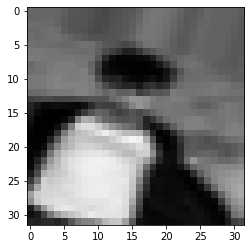

In [ ]:
batches=next(coarse_train_gen)  # returns the next batch of images and labels 
print(batches[0].shape) # batch[0] is the images, batch[1] are the labels
img=batches[0][0]   # this is the first image  batch[0][1] would be the next image
print (img.shape)
plt.imshow(img)   # shows the first image

In [ ]:
from keras.applications import VGG16, VGG19, MobileNetV2

In [ ]:
# base_model=MobileNetV2(classes=50, weights='imagenet', include_top=False, input_shape=(DIM,DIM,3))
base_model=VGG16(weights='imagenet', include_top=False, input_shape=(DIM,DIM,3))

base_model.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                              

In [ ]:
count=0
for layer in base_model.layers[:11]:
    # print(count,layer)
    # count+=1
    layer.trainable = False
# print(count)

In [ ]:
model=keras.Sequential([
    base_model,
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dropout(0.2),
    layers.Dense(512,activation='relu'),
    layers.Dense(50,activation='softmax')
])

In [ ]:

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 dropout (Dropout)           (None, 1, 1, 512)         0         
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dense_1 (Dense)             (None, 50)                25650     
                                                                 
Total params: 15,002,994
Trainable params: 13,267,506
No

In [ ]:
from keras.optimizers import Adam
import keras.backend as K
def f1_score(y_true, y_pred):
    def recall(y_true, y_pred):
      true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
      possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
      recall = true_positives / (possible_positives + K.epsilon())
      return recall

    def precision(y_true, y_pred):
      true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
      predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
      precision = true_positives / (predicted_positives + K.epsilon())
      return precision

    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy',f1_score])

In [ ]:
earlystop=tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=10,
    mode="auto",
    restore_best_weights=True,
)

In [ ]:
validation_steps=600//32
history1=model.fit(coarse_train_gen,
          validation_data=coarse_val_gen,
          epochs=100,
          validation_steps=validation_steps,
          verbose=1,
          callbacks=[earlystop]
          )

Epoch 1/100


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


750/750 [==============================] - 43s 43ms/step - loss: 3.6370 - accuracy: 0.0805 - f1_score: 0.0181 - val_loss: 3.1996 - val_accuracy: 0.1615 - val_f1_score: 0.0101
Epoch 2/100
750/750 [==============================] - 34s 45ms/step - loss: 3.0939 - accuracy: 0.1864 - f1_score: 0.0830 - val_loss: 2.7040 - val_accuracy: 0.2587 - val_f1_score: 0.1702
Epoch 3/100
750/750 [==============================] - 33s 43ms/step - loss: 2.7970 - accuracy: 0.2545 - f1_score: 0.1523 - val_loss: 2.6609 - val_accuracy: 0.3090 - val_f1_score: 0.2187
Epoch 4/100
750/750 [==============================] - 32s 42ms/step - loss: 2.6079 - accuracy: 0.2991 - f1_score: 0.2019 - val_loss: 2.5733 - val_accuracy: 0.3021 - val_f1_score: 0.2593
Epoch 5/100
750/750 [==============================] - 32s 43ms/step - loss: 2.4743 - accuracy: 0.3322 - f1_score: 0.2415 - val_loss: 2.3497 - val_accuracy: 0.3611 - val_f1_score: 0.3127
Epoch 6/100
750/750 [==============================] - 32s 43ms/step - loss: 

In [ ]:
base_model.trainable=True

model.compile(
    optimizer=Adam(learning_rate=0.00001),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy',f1_score])

validation_steps=600//32
history2 = model.fit(coarse_train_gen,
          validation_data=coarse_val_gen,
          epochs=100,
          validation_steps=validation_steps,
          verbose=1,
          callbacks=[earlystop]
          )

Epoch 1/100
750/750 [==============================] - 35s 45ms/step - loss: 1.5038 - accuracy: 0.5758 - f1_score: 0.5526 - val_loss: 1.9662 - val_accuracy: 0.4757 - val_f1_score: 0.4789
Epoch 2/100
750/750 [==============================] - 35s 46ms/step - loss: 1.4327 - accuracy: 0.5915 - f1_score: 0.5766 - val_loss: 2.0565 - val_accuracy: 0.4601 - val_f1_score: 0.4653
Epoch 3/100
750/750 [==============================] - 33s 45ms/step - loss: 1.3886 - accuracy: 0.6029 - f1_score: 0.5883 - val_loss: 1.8591 - val_accuracy: 0.5069 - val_f1_score: 0.5008
Epoch 4/100
750/750 [==============================] - 35s 46ms/step - loss: 1.3648 - accuracy: 0.6086 - f1_score: 0.5965 - val_loss: 1.9493 - val_accuracy: 0.4826 - val_f1_score: 0.5079
Epoch 5/100
750/750 [==============================] - 33s 44ms/step - loss: 1.3305 - accuracy: 0.6189 - f1_score: 0.6062 - val_loss: 1.9219 - val_accuracy: 0.5000 - val_f1_score: 0.4983
Epoch 6/100
750/750 [==============================] - 34s 45ms/s

In [ ]:
model.save('all.h5')

In [ ]:
def display_history(history, metric='accuracy'):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_{}'.format(metric)])
  plt.title('model {}'.format(metric))
  plt.ylabel(metric)
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()



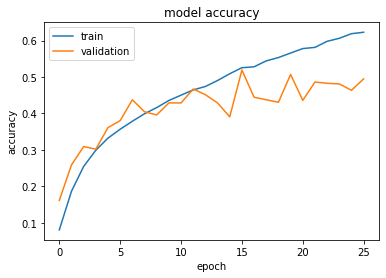

In [ ]:

display_history(history1, 'accuracy')



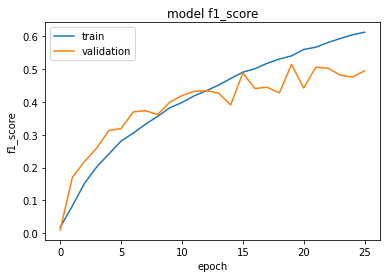

In [ ]:


display_history(history1, 'f1_score')

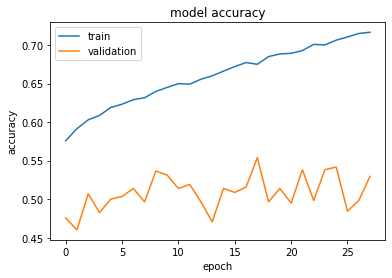

In [ ]:
display_history(history2, 'accuracy')


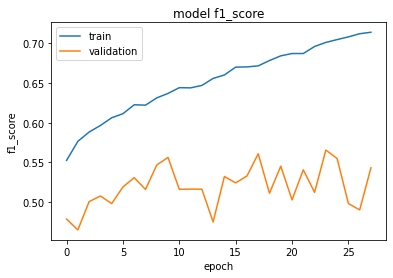

In [ ]:
display_history(history2, 'f1_score')
